# Graph Mining
One of the most powerful graph-handling modules in Python is [NetworkX](https://networkx.org/documentation/stable/index.html). It provides powerful data structures and algortihms for:
* reading, writing, and modifying graphs
* graph visualization
* graph analysis
* graph mining


You can learn the basics of `NetworkX` in [this tutorial](https://networkx.org/documentation/stable/tutorial.html). You can also find a list of all the algorithms they offer [here](https://networkx.org/documentation/stable/reference/algorithms/index.html). Finally, you can browse [this gallery](https://networkx.org/documentation/stable/auto_examples/index.html) to see different graph visualizations and tutorials to help you replicate them.

> **Note**  
> The terms network and graph are often used interchangeably, and so are their components: 

| Network Science | Graph Theory |
|:--------------- |:------------ |
| Network         | Graph        |
| Node            | Vertex       |
| Link            | Edge         |

> You can read [this article](https://bence.ferdinandy.com/2018/05/27/whats-the-difference-between-a-graph-and-a-network/) to get a better understanding of the so-called difference bewteen graphs and networks.

## Most Common Graph Mining Tasks
* Centrality Analysis (most important/connected node: high influence/reach)
  * Degree Centrality (node with highest degree)
  * Closeness Centrality (node with smallest avg shortest path to all other nodes)
* Link prediction/recommendation
* Community Mining
  * Community Detection

## Our Example: The Society of Friends (a.k.a. The Quakers)
Founded in England in the mid-seventeenth century, the Quakers were Protestant Christians who dissented from the official Church of England and promoted broad religious toleration, preferring Christians’ supposed “inner light” and consciences to state-enforced orthodoxy.

## What questions will we answer?
* What is the overall structure of the network?
* Who are the important people, or hubs, in the network?
* What are the subgroups and communities in the network?

## 1. Prepare the data

We have two files of data: a **node list** and **edge list**. They are both in CSV format.  

Each row in the in node list represents one person from the Quakers. Each column represents one of his/her attributes:
* Name	
* Historical Significance	
* Gender	
* Birthdate	(year)
* Deathdate (year)
* ID (in the [Six Degrees of Francis Bacon Project](http://www.sixdegreesoffrancisbacon.com/))

Each row in the edge list represents one connection between two members of the Quakers. The two columns thus represent the two connected members. Since if *member_1* knows *member_2*, then *member_2* must know *member_1*, the graph is **undirected**.

To **download** the data, we will use the `curl` utility. It requires a URL to download the data from, and we will also provide a file name to save this data to. We use the flag `-o` to specify that name/path of the file where the download should be saved.

In [1]:
# dowload list of nodes and save them as nodes.csv
!curl https://programminghistorian.org/assets/exploring-and-analyzing-network-data-with-python/quakers_nodelist.csv -o nodes.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7471  100  7471    0     0  47585      0 --:--:-- --:--:-- --:--:-- 47585


In [2]:
# download list of edges and save them as edges.csv
!curl https://programminghistorian.org/assets/exploring-and-analyzing-network-data-with-python/quakers_edgelist.csv -o edges.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5047  100  5047    0     0   114k      0 --:--:-- --:--:-- --:--:--  114k


## 2. Load data into a NetworkX graph
As always, we will load the CSV files into pandas dataframes. Then, we will use the edge list to generate a graph.  
The edge list identifies a node by the name of the person it represents. Thus, the main ideifitier/key/label of every node will be the name of the perosn.

In [3]:
# import required modules and functions
import csv
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
import pylab as plt
import pandas as pd

In [4]:
# read nodes into a pandas data frame
nodes_df = pd.read_csv('nodes.csv')

# show the first 5 rows
nodes_df.head()

,Name,Historical Significance,Gender,Birthdate,Deathdate,ID
0,Joseph Wyeth,religious writer,male,1663,1731,10013191
1,Alexander Skene of Newtyle,local politician and author,male,1621,1694,10011149
2,James Logan,colonial official and scholar,male,1674,1751,10007567
3,Dorcas Erbery,Quaker preacher,female,1656,1659,10003983
4,Lilias Skene,Quaker preacher and poet,male,1626,1697,10011152


In [5]:
# read edges into a pandas data frame
edges_df = pd.read_csv('edges.csv')

# show the first 5 rows
edges_df.head()

,Source,Target
0,George Keith,Robert Barclay
1,George Keith,Benjamin Furly
2,George Keith,Anne Conway Viscountess Conway and Killultagh
3,George Keith,Franciscus Mercurius van Helmont
4,George Keith,William Penn


In [6]:
# initialize a grpah from the the edge list loaded into pandas
G = nx.from_pandas_edgelist(edges_df,source='Source', target='Target')

## 3. Add Attributes to the Nodes
While nodes and edges represent the most basic components of the graph, each one of them can be augmented with attributes. These attributes give more context about the nodes and about the relationship between the nodes (i.e., the edges).  
These attributes can be used late on to analyse the graph.  
Moreover, we save the result of our analysis as an attribute to either nodes or edges (depending on the nature of the analysis), which makes it easier to retrieve this result in the future or visualize it.

In [7]:
# create an empty dictionary to add the attributes to
# - key: node identifier (in our case the name)
# - value: the atrributes to be added to the node
attrs = {}

# loop over the rows of the nodes dataframe to add the attributes of each person
# to the dictionary
for index, person in nodes_df.iterrows():
  # extract the key (the name of the person)
  name = person['Name']
  # create an empty dictionary of attributes for this person
  attrs[name] = {}
  # add the attributes of this person to their dictionary
  attrs[name]['historical_significance'] = person['Historical Significance']
  attrs[name]['gender'] = person['Gender']
  attrs[name]['birth_year'] = person['Birthdate']
  attrs[name]['death_year'] = person['Deathdate']
  attrs[name]['sfdb_id'] = person['ID']

# add the attributes to the nodes
nx.set_node_attributes(G, attrs)

# loop over all nodes and print their attributes
# for n in G.nodes():
#     print(n, G.nodes[n])

## 4. Exploring the metrics offered by NetworkX

### 4.1. The shape of the network

#### 4.1.1. Visualization

Just like we do in other datasets, the first step of exploration is to visualize the data. To do so, we call `NetworkX`'s `draw()` function.

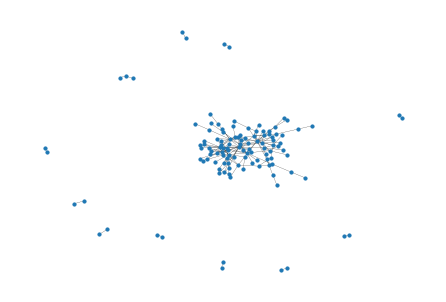

In [8]:
nx.draw(G, width=0.2, node_size=10)

We can also use interactive visualizations to do more manual exploration of the network. The [pyvis]() module makes this possible, and it has a very clean integration with `NetworkX`.  
It creates an HTML file that we can display in the notebook.
> For a notebook to display an HTML file, both files must be in the same directory. Since google colab has its own file system structure, the generated HTML file is not placed in the same directory as the notebook file. So, we must use `IPython.core.display` to read the HTML file and display it as opposed to simply using `pyvis`' `show()` (which would work in a local Jupyter notebook).

In [9]:
# use pip to install pyvis
%%capture
!pip install pyvis

In [10]:
from pyvis.network import Network
from IPython.core.display import display, HTML

# initialize the network object with desired height and width
nt = Network('500px', '700px', notebook=True, cdn_resources='remote')
# populate the nodes and edges data structures from the NetworkX object
nt.from_nx(G)

nt.show('G.html')
# for the sake of colab's file system, read the HTML file and display it
display(HTML('G.html'))

Upon observation, we can see that the network has one big community, and a few connected pairs that are not part of this main community.  

#### 4.1.2. Density

The next thing we want to explore is the **density** of the graph:
* if all nodes are connected to all other nodes, we would have a density of 1
* if no nodes are connected at all, we would have a density of 0

In [11]:
density = nx.density(G)
print("Network density:", density)

Network density: 0.02478279447372169


This goes in line with what we see in the visualization of the graph. We see that not all nodes are connected to each other, but some nodes are.

#### 4.1.3. Shortest Path

Another common exploration is finding the shortest path between a couple of nodes in the graph. To do so, we conveniently use the `shortest_path()` method.

In [12]:
# find the shortest path between Margaret Fell and George Whitehead
fell_whitehead_path = nx.shortest_path(
    G, source='Margaret Fell', target='George Whitehead'
)

print("Shortest path between Fell and Whitehead:", fell_whitehead_path)

Shortest path between Fell and Whitehead: ['Margaret Fell', 'George Fox', 'George Whitehead']


In [13]:
# print the length of that shortest path
print("Length of that path:", len(fell_whitehead_path)-1)

Length of that path: 2


#### 4.1.4. Diameter

The diameter is the longest of all shortest paths. It tells us something about the overall connectedness and density of the graph.

In [14]:
# If your Graph has more than one component, this will return False:
print("Graph is connected:", nx.is_connected(G))

# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(G)
largest_component = max(components, key=len)

# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.
#
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

Graph is connected: False
Network diameter of largest component: 8


### 4.2. Centrality
Centrality speaks to the importance or infleunce of a certain node in the graph.
The higher the node's *measure of* centrality, the more important/influential it is. The highly connected nodes (a.k.a. nodes with a high measure of centrality) are often called **hubs**.  
There are a few different measures of centrality.


#### 4.2.1. Degree
Degree is the simplest form of centrality. A node's degree is the number of links it has.

In [15]:
# save the degree of every node into a dictionary
# - key: the node's indentifier (the name of the person)
# - value: the node's degree
degree_dict = dict(G.degree(G.nodes()))

# add the degree as an attribute to the node
nx.set_node_attributes(G, degree_dict, 'degree')

Now, let's find out which members of the quakers has the most direct connections.

In [16]:
# sort the nodes by descending order of degree
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

# print the nodes with the top 20 highest degree
print("Top 20 nodes by degree:")
for name, deg in sorted_degree[:20]:
    print(f"{name:<20}{deg}")

Top 20 nodes by degree:
George Fox          22
William Penn        18
James Nayler        16
George Whitehead    13
Margaret Fell       13
Benjamin Furly      10
Edward Burrough     9
George Keith        8
Thomas Ellwood      8
Francis Howgill     7
John Perrot         7
John Audland        6
Richard Farnworth   6
John Story          6
Alexander Parker    6
John Wilkinson      5
John Stubbs         5
William Caton       5
Anthony Pearson     5
Thomas Curtis       5


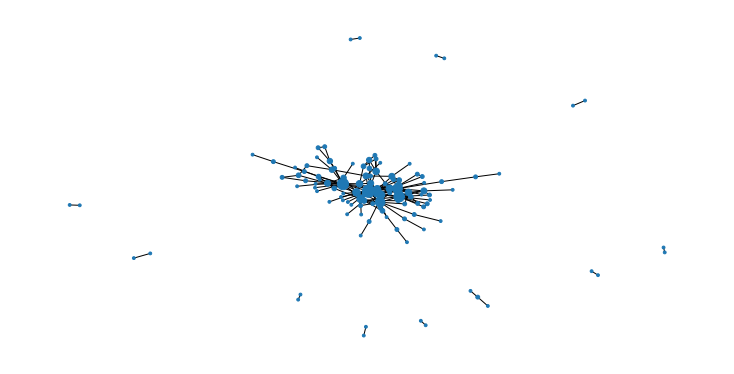

In [17]:
# visualize graph where node size is a factor of the node degree

list_degree=list(G.degree()) #this will return a list of tuples each tuple is(node,deg)
nodes, degree = map(list, zip(*list_degree)) #build a node list and corresponding degree list
plt.figure(figsize=(10,5))
nx.draw(G, node_size=[(v * 7)+1 for v in degree])
plt.show()

#### 4.2.2. Eigenvector centrality

Eigenvector centrality is a kind of extension of degree—it looks at a combination of a node’s edges and the edges of that node’s neighbors.  

Eigenvector centrality cares if you are a hub, but it also cares how many hubs you are connected to. It’s calculated as a value from 0 to 1: the closer to one, the greater the centrality.  

Eigenvector centrality is useful for understanding which nodes can get information to many other nodes quickly. If you know a lot of well-connected people, you could spread a message very efficiently.

In [18]:
# Run eigenvector centrality
eigenvector_dict = nx.eigenvector_centrality(G)

# Assign it to an attribute in your network
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

#### 4.2.3. Betweenness centrality

Betweenness centrality is a bit different from the other two measures in that it doesn’t care about the number of edges any one node or set of nodes has. Betweenness centrality looks at all the shortest paths that pass through a particular node (see above).  

To do this, it must first calculate every possible shortest path in your network, so keep in mind that betweenness centrality will take longer to calculate than other centrality measures (but it won’t be an issue in a dataset of this size).   

Betweenness centrality, which is also expressed on a scale of 0 to 1, is fairly good at finding nodes that connect two otherwise disparate parts of a network. If you’re the only thing connecting two clusters, every communication between those clusters has to pass through you. In contrast to a hub, this sort of node is often referred to as a broker.

In [19]:
 # Run betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)

# Assign it to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')

In [20]:
# sort the nodes by descending order of betweenness centrality
sorted_betweenness = sorted(
    betweenness_dict.items(), key=itemgetter(1), reverse=True)

# print the nodes with the top 20 betweenness centrality
print("Top 20 nodes by betweenness centrality:")
for name, deg in sorted_betweenness[:20]:
    print(f"{name:<20}{deg}")

Top 20 nodes by betweenness centrality:
William Penn        0.23999456006192194
George Fox          0.23683257726065213
George Whitehead    0.12632024847366005
Margaret Fell       0.12106792237170327
James Nayler        0.1044602628044609
Benjamin Furly      0.06419626175167245
Thomas Ellwood      0.04619062388510455
George Keith        0.04500656400917155
John Audland        0.041649363400775824
Alexander Parker    0.03893676140525336
John Story          0.028990098622866962
John Burnyeat       0.028974117533439567
John Perrot         0.028295668549905836
Robert Barclay      0.026944806605823553
James Logan         0.026944806605823553
Richard Claridge    0.026944806605823553
Elizabeth Leavens   0.026944806605823553
Thomas Curtis       0.026729751729751727
John Stubbs         0.024316593960227156
Mary Penington      0.02420824624214455


In [21]:
# compare degree and betweenness centrality

#First get the top 20 nodes by betweenness as a list
top_betweenness = sorted_betweenness[:20]

#Then find and print their degree
print("Name              | Betweenness Centrality | Degree")
for tb in top_betweenness: # Loop through top_betweenness
  name = tb[0]
  degree = degree_dict[name] # Use degree_dict to access a node's degree, see footnote 2
  print(f"{name:<17} | {tb[1]:<22} | {degree}")

Name              | Betweenness Centrality | Degree
William Penn      | 0.23999456006192194    | 18
George Fox        | 0.23683257726065213    | 22
George Whitehead  | 0.12632024847366005    | 13
Margaret Fell     | 0.12106792237170327    | 13
James Nayler      | 0.1044602628044609     | 16
Benjamin Furly    | 0.06419626175167245    | 10
Thomas Ellwood    | 0.04619062388510455    | 8
George Keith      | 0.04500656400917155    | 8
John Audland      | 0.041649363400775824   | 6
Alexander Parker  | 0.03893676140525336    | 6
John Story        | 0.028990098622866962   | 6
John Burnyeat     | 0.028974117533439567   | 4
John Perrot       | 0.028295668549905836   | 7
Robert Barclay    | 0.026944806605823553   | 3
James Logan       | 0.026944806605823553   | 4
Richard Claridge  | 0.026944806605823553   | 2
Elizabeth Leavens | 0.026944806605823553   | 2
Thomas Curtis     | 0.026729751729751727   | 5
John Stubbs       | 0.024316593960227156   | 5
Mary Penington    | 0.02420824624214455    | 4


## 5. Community Detection

Is your network one big, happy family where everyone knows everyone else? Or is it a collection of smaller subgroups that are only connected by one or two intermediaries? The field of community detection in networks is designed to answer these questions.

**Modularity** is a measure of relative density in your network: a community (called a module or modularity class) has high density relative to other nodes within its module but low density with those outside.

Very dense networks are often more difficult to split into sensible partitions. Luckily, as you discovered earlier, this network is not all that dense. There aren’t nearly as many actual connections as possible connections, and there are several altogether disconnected components. Its worthwhile partitioning this sparse network with modularity and seeing if the result make historical and analytical sense.

In [22]:
communities = community.greedy_modularity_communities(G)

Now that the modularity algorithm found a list of communities, let's add the community indices as attributes to the nodes so we can retrieve them later, and maybe visualize them.

In [23]:
# Create a blank dictionary
modularity_dict = {}

# Loop through the list of communities, keeping track of the number for the community
for community_index, community in enumerate(communities):
  # Loop through each person in a community
  for name in community:
    # Create an entry in the dictionary for the person, where the value is which group they belong to.
    modularity_dict[name] = community_index

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')

As always, we can combine these measures with others. For example, here’s how we find the highest eigenvector centrality nodes in modularity class 0 (the first one):

In [24]:
# First get a list of just the nodes in that class
class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n: G.nodes[n]['eigenvector'] for n in class0}

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(
    class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:5]:
  print(f"{node[0]:<17} | {node[1]}")

Modularity Class 0 Sorted by Eigenvector Centrality:
William Penn      | 0.2703220115399868
George Keith      | 0.18384690867915346
William Bradford  | 0.06812170326615952
Tace Sowle        | 0.04688085927497435
James Logan       | 0.04447446026748654


In smaller networks like this one, a common task is to find and list all of the modularity classes and their members. We can do this by looping through the communities list:

In [25]:
# Loop through the list of communities
for community_index, community in enumerate(communities):
  # Filter out modularity classes with 2 or fewer nodes
  if len(community) > 2:
    # Print out the classes and their members
    print('Class '+str(community_index)+':', list(community))

Class 0: ['George Keith', 'Isabel Yeamans', 'Richard Claridge', 'William Penn', 'Isaac Norris', 'William Bradford', 'Thomas Story', 'Samuel Bownas', 'Tace Sowle', 'John Bartram', 'Edward Haistwell', 'Joseph Besse', 'Anne Conway Viscountess Conway and Killultagh', 'James Logan', 'David Lloyd', 'Jane Sowle', 'Peter Collinson']
Class 1: ['Francis Howgill', 'Robert Rich', 'Margaret Fell', 'Elizabeth Leavens', 'Gervase Benson', 'William Gibson', 'George Fox the younger', 'Martha Simmonds', 'Richard Farnworth', 'Dorcas Erbery', 'Thomas Lower', 'Hannah Stranger', 'Thomas Holme', 'William Tomlinson', 'James Nayler', 'Thomas Aldam', 'Anthony Pearson']
Class 2: ['Leonard Fell', 'Thomas Salthouse', 'John Perrot', 'George Fox', 'William Dewsbury', 'William Crouch', 'Elizabeth Hooten', 'Mary Prince', 'William Coddington', 'Mary Fisher', 'John Crook', 'Edward Burrough', 'William Mead', 'Ellis Hookes', 'William Mucklow']
Class 3: ['John Whitehead', 'Alice Curwen', 'Gilbert Latey', 'Lewis Morris', 'Ri

Notice in the code above that you are filtering out any modularity classes with two or fewer nodes, in the line `if len(community) > 2`. Recall from the visualization that there were lots of small components of the network with only two nodes. Modularity will find these components and treat them as separate classes (since they’re not connected to anything else). By filtering them out, we get a better sense of the larger modularity classes within the network’s main component.

Finally, we can visualize the graph where the colors of the nodes determine their community membership and their size dtermine their degree.

> Code adapted from [this stackoverflow post](https://stackoverflow.com/questions/28910766/python-networkx-set-node-color-automatically-based-on-number-of-attribute-opt)

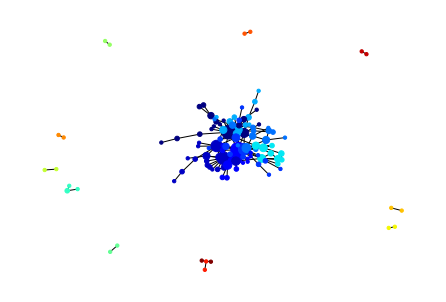

In [26]:
# create number for each group to allow use of colormap
from itertools import count
# get unique groups
groups = set(nx.get_node_attributes(G,'modularity').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['modularity']] for n in nodes]
list_degree=list(G.degree()) #this will return a list of tuples each tuple is(node,deg)
nodes , degree = map(list, zip(*list_degree)) #build a node list and corresponding degree list

nx.draw(G, 
        node_color=colors, 
        cmap=plt.cm.jet, 
        node_size=[(v * 10)+1 for v in degree])

## 6. Export data

There are many encodings/formats of graph data that are used by diffrent softwares and standards. `NetworkX` provides functions to export the graph into these different formats:
* dot
* pandas dataframe (edge/adjacency list)
* gexf
* numpy array/matrix

Most of the export options work in roughly the same way, so for this tutorial you’ll learn how to export your data into Gephi’s GEXF format. Once you’ve exported the file, you can upload it [directly into Gephi](https://gephi.org/users/supported-graph-formats/) for visualization.

In [27]:
# save the graph as a gefx to quaker_network.gefx
nx.write_gexf(G, 'quaker_network.gexf')

## Acknowlegdments
Adapted from [Exploring and Analyzing Network Data with Python](https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python).